In [1]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from lxml import etree

# Define paths to annotation and image directories
annotations_dir = "/content/drive/MyDrive/annotations"
images_dir = "/content/drive/MyDrive/images"

# Define classes
classes = ['With Helmet', 'Without Helmet']

# Parse XML annotations
def parse_annotation(annotation_file):
    tree = etree.parse(annotation_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text), int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text), int(bbox.find('ymax').text)]
        objects.append(obj_struct)
    return objects

# Load images and annotations
def load_data(annotations_dir, images_dir):
    X, y = [], []
    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            objects = parse_annotation(annotation_path)
            image_path = os.path.join(images_dir, annotation_file.replace('.xml', '.png'))
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            X.append(preprocess_input(image))
            labels = [0] * len(classes)
            for obj in objects:
                label_idx = classes.index(obj['name'])
                labels[label_idx] = 1
            y.append(labels)
    return np.array(X), np.array(y)

# Load and preprocess data
X_train, y_train = load_data(annotations_dir, images_dir)

# Define Faster R-CNN model
def create_faster_rcnn():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(len(classes), activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

# Compile model
model = create_faster_rcnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 8s/step - accuracy: 0.7073 - loss: 0.7644 - val_accuracy: 0.7582 - val_loss: 0.5393
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.8128 - loss: 0.4251 - val_accuracy: 0.8039 - val_loss: 0.4825
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.8367 - loss: 0.3374 - val_accuracy: 0.7647 - val_loss: 0.4652
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 217s 8s/step - accuracy: 0.8870 - loss: 0.2996 - val_accuracy: 0.7974 - val_loss: 0.4576
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - accuracy: 0.8760 - loss: 0.2753 - val_accuracy: 0.7647 - val_loss: 0.4807
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - accuracy: 0.9046 - loss: 0.2355 - val_accuracy: 0.8105 - val_loss: 0.4355
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step - accuracy: 0.9304 - loss: 0.2049 - val_accuracy: 0.8039 - val_loss: 0.4472
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accurac

In [3]:
model.save("/content/drive/MyDrive/helmet_detection_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[9.9840605e-01 9.0698566e-04]]
Prediction for BikesHelmets0.png : With Helmet


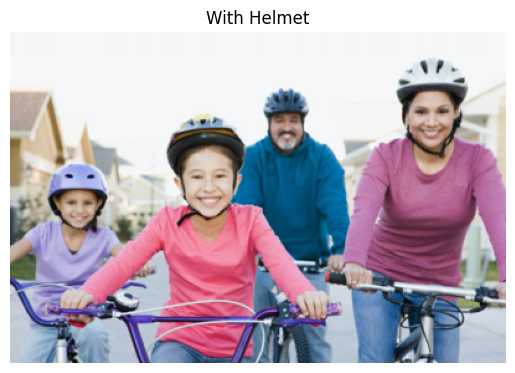

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
[[0.99940056 0.00267696]]
Prediction for BikesHelmets100.png : With Helmet


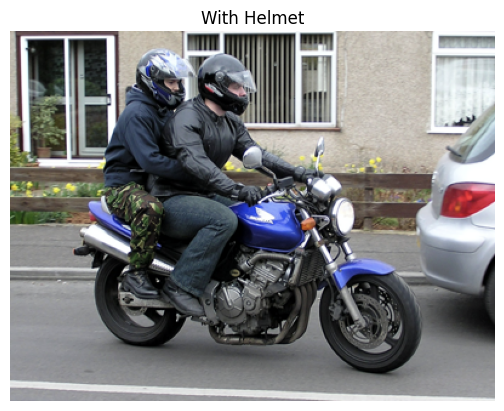

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
[[0.97518426 0.04517643]]
Prediction for BikesHelmets105.png : With Helmet


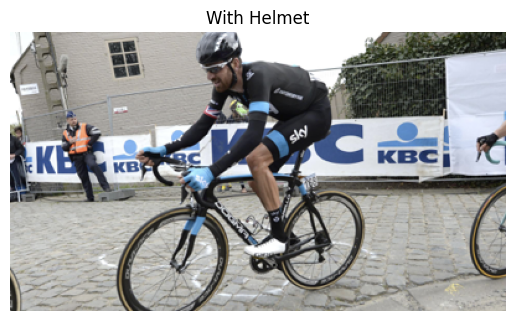

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
[[0.50269884 0.39366305]]
Prediction for BikesHelmets111.png : Without Helmet


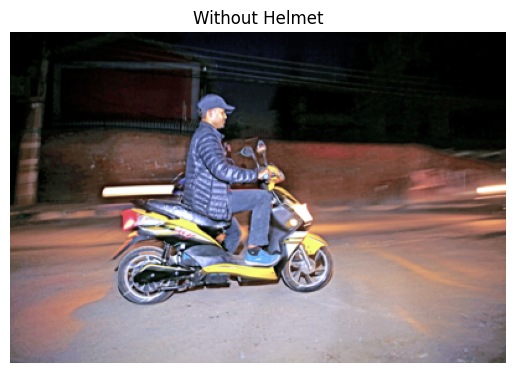

In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/helmet_detection_model.h5")

# Function to preprocess the input image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Function to make predictions on images
def predict_image(image_path, model):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    print(prediction)
    return prediction

# Function to interpret the prediction
def interpret_prediction(prediction, threshold=0.6):
    if prediction > threshold:
        return "With Helmet"
    else:
        return "Without Helmet"

# Function to display image with prediction
def display_image_with_prediction(image_path, prediction_text):
    image = load_img(image_path)
    plt.imshow(image)
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

# Path to test images
test_images_dir = "/content/drive/MyDrive/images"

# Choose some images to test
image_filenames = [
    "BikesHelmets0.png",
    "BikesHelmets100.png",
    "BikesHelmets105.png",
    "BikesHelmets111.png"
    # Add more image filenames as needed
]

# Make predictions on test images
for image_filename in image_filenames:
    image_path = os.path.join(test_images_dir, image_filename)
    prediction = predict_image(image_path, loaded_model)
    result = interpret_prediction(prediction[0][0])  # Assuming the model output is in the form [[probability]]
    print("Prediction for", image_filename, ":", result)
    display_image_with_prediction(image_path, result)
